# **Business Use Case 1**

## Regression model for predicting the amount that customers will spend in the next month

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 0. Import Packages

In [2]:
!pip install -r https://raw.githubusercontent.com/phuonganh-38/transaction-analysis-ML/main/requirements.txt

In [3]:
import csv
import os
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1.   Load Dataset

In [4]:
#Merge all transactions
data_folder = '/content/drive/My Drive/Transaction Analysis - ML/Transactions'

data = []

for file_csv in os.listdir(data_folder):
    if file_csv.endswith('.csv'):
        file_path = os.path.join(data_folder, file_csv)
        features = pd.read_csv(file_path, sep='|')
        data.append(features)

transactions = pd.concat(data, ignore_index=True)
print(transactions)

                   cc_num      acct_num                         trans_num  \
0           4218196001337  888022315787  91ab12e73ef38206e1121e9648d2408d   
1           4218196001337  888022315787  071553d533a6822a4431c354c434ddcb   
2           4218196001337  888022315787  0cfad38ef15e4749eff68dc83f62c151   
3           4218196001337  888022315787  5782693d7c70f062f258cb30bfa8900f   
4           4218196001337  888022315787  35fd7db657d7e30dd608c37f7798186e   
...                   ...           ...                               ...   
4260899  4413395479406453  929002904576  660c294fe8d540431cc54d25077dc4d1   
4260900  4413395479406453  929002904576  4be02c8434ff59abf1d72f2b8372be0f   
4260901  4413395479406453  929002904576  0b9f714b93b5b1369cdd4fbbc111297d   
4260902  4413395479406453  929002904576  db1d2149e9c939413b0a33b672b496f2   
4260903  4413395479406453  929002904576  fa5d1154d8add5ac13931ab0008df642   

          unix_time       category    amt is_fraud        merchant  merch_l

In [5]:
#Load customers dataset
# Define the function to separate values into columns
def separate_values(file_path):
    with open(file_path, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter='|')
        columns = next(reader)  # Get the column names from the first row
        data = list(reader)     # Get the remaining rows as data

    return columns, data

# File URL
file_url = '/content/drive/My Drive/Transaction Analysis - ML/customers.csv'

# Call the function to separate values into columns
columns, data = separate_values(file_url)

# Convert data into a DataFrame
customers = pd.DataFrame(data, columns=columns)
customers

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,acct_num
0,115-04-4507,4218196001337,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03,888022315787
1,715-55-5575,4351161559407816183,Elaine,Fuller,F,310 Kendra Common Apt. 164,Leland,NC,28451,34.268,-78.0578,27112,Professor Emeritus,1963-06-07,917558277935
2,167-48-5821,4192832764832,Michael,Cameron,M,05641 Robin Port,Cordova,SC,29039,33.4275,-80.8857,4215,International aid/development worker,1973-05-30,718172762479
3,406-83-7518,4238849696532874,Brandon,Williams,M,26916 Carlson Mountain,Birmingham,AL,35242,33.3813,-86.7046,493806,Seismic interpreter,1942-12-26,947268892251
4,697-93-1877,4514627048281480,Lisa,Hernandez,F,809 Burns Creek,Fargo,GA,31631,30.7166,-82.5801,559,Medical laboratory scientific officer,1939-05-22,888335239225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,392-96-7670,30125158904184,Sarah,Martin,F,1666 Jenna Unions,Denver,CO,80236,39.6535,-105.0376,990452,Colour technologist,1993-08-31,201218361926
996,594-17-7993,180047909863618,Erin,Wells,F,444 Alexis Estate Suite 824,Wasco,CA,93280,35.648,-119.4487,27152,Software engineer,1982-05-27,921460407733
997,196-93-1156,4371450311809,Michael,James,M,914 Cassandra Gateway Suite 061,Escondido,CA,92026,33.1605,-117.0978,171802,Agricultural consultant,1999-05-14,499348764671
998,895-65-9304,3519925692476886,Michael,Lewis,M,34141 Katelyn Path,Mattapan,MA,2126,42.2739,-71.0939,25562,Civil Service administrator,1994-02-23,617852071065


In [6]:
# Remove spaces from 'cc_num' and 'acct_num' column
transactions['cc_num'] = transactions['cc_num'].replace(' ', '')
customers['cc_num'] = customers['cc_num'].replace(' ', '')
transactions['acct_num'] = transactions['acct_num'].replace(' ', '')
customers['acct_num'] = customers['acct_num'].replace(' ', '')

#Astype 'cc_num' and 'acct_num'
transactions['cc_num'] = transactions['cc_num'].astype(float)
transactions['acct_num'] = transactions['acct_num'].astype(float)
customers['cc_num'] = customers['cc_num'].astype(float)
customers['acct_num'] = customers['acct_num'].astype(float)

In [7]:
#Merge dataset
df = transactions.merge(customers, how='left', on=['cc_num', 'acct_num'])
df

,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,...,gender,street,city,state,zip,lat,long,city_pop,job,dob
0,4.218196e+12,8.880223e+11,91ab12e73ef38206e1121e9648d2408d,1558719550,gas_transport,69.12,0,Phillips Group,39.491416,-75.588522,...,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03
1,4.218196e+12,8.880223e+11,071553d533a6822a4431c354c434ddcb,1569425519,grocery_pos,68.11,0,Tucker Ltd,40.890319,-75.573359,...,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03
2,4.218196e+12,8.880223e+11,0cfad38ef15e4749eff68dc83f62c151,1577205601,misc_net,40.35,0,Dixon PLC,39.244958,-74.475327,...,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03
3,4.218196e+12,8.880223e+11,5782693d7c70f062f258cb30bfa8900f,1571428238,grocery_pos,96.22,0,Lambert-Cooper,39.656925,-75.802342,...,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03
4,4.218196e+12,8.880223e+11,35fd7db657d7e30dd608c37f7798186e,1549840400,gas_transport,71.89,0,Griffith LLC,40.313342,-74.220434,...,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4260899,4.413395e+15,9.290029e+11,660c294fe8d540431cc54d25077dc4d1,1670377413,kids_pets,2.89,0,Morris-Tran,34.687688,-118.891984,...,F,790 Sharp Crossing Apt. 898,West Covina,CA,91791,34.0653,-117.8978,108175,Occupational therapist,1966-06-19
4260900,4.413395e+15,9.290029e+11,4be02c8434ff59abf1d72f2b8372be0f,1664342570,home,9.63,0,Lopez PLC,34.381254,-117.017665,...,F,790 Sharp Crossing Apt. 898,West Covina,CA,91791,34.0653,-117.8978,108175,Occupational therapist,1966-06-19
4260901,4.413395e+15,9.290029e+11,0b9f714b93b5b1369cdd4fbbc111297d,1672056151,travel,1.78,0,Sanchez Ltd,33.151970,-118.836058,...,F,790 Sharp Crossing Apt. 898,West Covina,CA,91791,34.0653,-117.8978,108175,Occupational therapist,1966-06-19
4260902,4.413395e+15,9.290029e+11,db1d2149e9c939413b0a33b672b496f2,1668741851,kids_pets,8.18,0,Garcia PLC,33.925622,-118.417269,...,F,790 Sharp Crossing Apt. 898,West Covina,CA,91791,34.0653,-117.8978,108175,Occupational therapist,1966-06-19


### 2. Explore Dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4260904 entries, 0 to 4260903
Data columns (total 23 columns):
 #   Column      Dtype  
---  ------      -----  
 0   cc_num      float64
 1   acct_num    float64
 2   trans_num   object 
 3   unix_time   object 
 4   category    object 
 5   amt         float64
 6   is_fraud    object 
 7   merchant    object 
 8   merch_lat   float64
 9   merch_long  float64
 10  ssn         object 
 11  first       object 
 12  last        object 
 13  gender      object 
 14  street      object 
 15  city        object 
 16  state       object 
 17  zip         object 
 18  lat         object 
 19  long        object 
 20  city_pop    object 
 21  job         object 
 22  dob         object 
dtypes: float64(5), object(18)
memory usage: 747.7+ MB


In [9]:
df.describe()

,cc_num,acct_num,amt,merch_lat,merch_long
count,4.260904e+06,4.260904e+06,4.260904e+06,4.260904e+06,4.260904e+06
mean,3.916811e+17,4.913599e+11,6.898790e+01,3.735276e+01,-9.247610e+01
std,1.267805e+18,2.897749e+11,1.618467e+02,5.504630e+00,1.741603e+01
min,6.040027e+10,2.348758e+09,1.000000e+00,1.859001e+01,-1.603677e+02
25%,1.800618e+14,2.568452e+11,9.100000e+00,3.370138e+01,-9.903072e+01
50%,3.524238e+15,4.719310e+11,4.449000e+01,3.819365e+01,-8.727445e+01
75%,4.604409e+15,7.518511e+11,8.158000e+01,4.120567e+01,-7.966098e+01
max,4.986227e+18,9.993899e+11,4.130053e+04,6.577610e+01,-6.724632e+01


In [10]:
df.shape

(4260904, 23)

### 3. Data pre-processing

In [11]:
#Convert unix timestamp to datetime
df['transaction time'] = pd.to_datetime(df['unix_time'], unit='s')

#Extract year_month of transaction
df['trans_year_month'] = df['transaction time'].dt.to_period('M')

In [12]:
#Rename columns
df=df.rename(columns={'cc_num':'credit card number',
                      'acct_num':'account number',
                      'trans_num': 'transaction number',
                      'amt': 'amount',
                      'merch_lat': 'merchant lattitude',
                      'merch_long': 'merchant longitude',
                      'city_pop': 'population of city',
                      'zip': 'zipcode',
                      'lat': 'transaction lattitude',
                      'long': 'transaction longitude'})

In [13]:
#Create a new column 'card_holder' by concatenating 'first' and 'last' names
df['card holder'] = df['first'] + ' ' + df['last']

#Drop columns
df.drop(['first', 'last'], axis=1, inplace=True)

In [14]:
#Calculate cardholders age
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = (2024  - df['dob'].dt.year)

In [15]:
print(df['age'].min())
print(df['age'].max())

17
97


In [16]:
#Divide ages into 4 age groups
for i in range(len(data)):
    if((df['age'] <= 24).empty):
        df.iloc[i,100] = '17-24'
    elif(df['age'].between(25, 44).empty):
         df.iloc[i,100] = '25-44'
    elif(df['age'].between(45, 69).empty):
         df.iloc[i,100] = '45-69'
    elif((df['age'] >= 70).empty):
         df.iloc[i,100] = '70+'

conditions = [
    (df['age'] <= 24),
    (df['age'].between(25, 44)),
    (df['age'].between(45, 69)),
    (df['age'] >= 70)]
choices = ['17-24', '25-44', '45-69', '70+']
df['age group'] = np.select(conditions, choices, default='')

In [17]:
#Define desired column order
order = ['card holder', 'credit card number', 'account number', 'dob', 'age', 'age group',
         'gender', 'job', 'ssn', 'street', 'zipcode', 'city', 'state',
         'transaction lattitude', 'transaction longitude', 'population of city',
         'transaction number', 'transaction time', 'trans_year_month','category', 'amount','merchant',
         'merchant lattitude', 'merchant longitude', 'is_fraud']

#Reindex the DataFrame with the desired column order
df=df.reindex(columns=order)

In [18]:
#Drop unnecessary columns
df = df.drop(columns=['ssn', 'transaction lattitude', 'gender', 'transaction longitude', 'merchant lattitude',
       'merchant longitude', 'transaction time'])
df

,card holder,credit card number,account number,dob,age,age group,job,street,zipcode,city,state,population of city,transaction number,trans_year_month,category,amount,merchant,is_fraud
0,Jonathan Johnson,4.218196e+12,8.880223e+11,1959-10-03,65,45-69,Accounting technician,863 Lawrence Valleys,19002,Ambler,PA,32412,91ab12e73ef38206e1121e9648d2408d,2019-05,gas_transport,69.12,Phillips Group,0
1,Jonathan Johnson,4.218196e+12,8.880223e+11,1959-10-03,65,45-69,Accounting technician,863 Lawrence Valleys,19002,Ambler,PA,32412,071553d533a6822a4431c354c434ddcb,2019-09,grocery_pos,68.11,Tucker Ltd,0
2,Jonathan Johnson,4.218196e+12,8.880223e+11,1959-10-03,65,45-69,Accounting technician,863 Lawrence Valleys,19002,Ambler,PA,32412,0cfad38ef15e4749eff68dc83f62c151,2019-12,misc_net,40.35,Dixon PLC,0
3,Jonathan Johnson,4.218196e+12,8.880223e+11,1959-10-03,65,45-69,Accounting technician,863 Lawrence Valleys,19002,Ambler,PA,32412,5782693d7c70f062f258cb30bfa8900f,2019-10,grocery_pos,96.22,Lambert-Cooper,0
4,Jonathan Johnson,4.218196e+12,8.880223e+11,1959-10-03,65,45-69,Accounting technician,863 Lawrence Valleys,19002,Ambler,PA,32412,35fd7db657d7e30dd608c37f7798186e,2019-02,gas_transport,71.89,Griffith LLC,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4260899,Cindy Frazier,4.413395e+15,9.290029e+11,1966-06-19,58,45-69,Occupational therapist,790 Sharp Crossing Apt. 898,91791,West Covina,CA,108175,660c294fe8d540431cc54d25077dc4d1,2022-12,kids_pets,2.89,Morris-Tran,0
4260900,Cindy Frazier,4.413395e+15,9.290029e+11,1966-06-19,58,45-69,Occupational therapist,790 Sharp Crossing Apt. 898,91791,West Covina,CA,108175,4be02c8434ff59abf1d72f2b8372be0f,2022-09,home,9.63,Lopez PLC,0
4260901,Cindy Frazier,4.413395e+15,9.290029e+11,1966-06-19,58,45-69,Occupational therapist,790 Sharp Crossing Apt. 898,91791,West Covina,CA,108175,0b9f714b93b5b1369cdd4fbbc111297d,2022-12,travel,1.78,Sanchez Ltd,0
4260902,Cindy Frazier,4.413395e+15,9.290029e+11,1966-06-19,58,45-69,Occupational therapist,790 Sharp Crossing Apt. 898,91791,West Covina,CA,108175,db1d2149e9c939413b0a33b672b496f2,2022-11,kids_pets,8.18,Garcia PLC,0


### 4. Explore Target variable

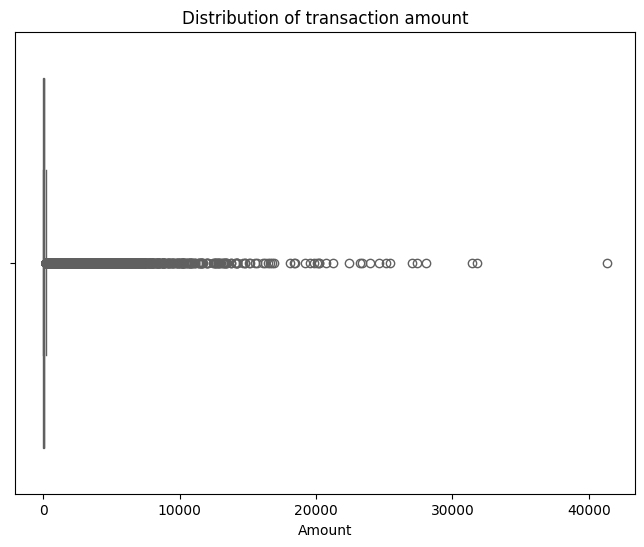

In [19]:
#Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='amount', palette='Blues')
plt.title('Distribution of transaction amount')
plt.xlabel('Amount')
plt.show()

### 5. Explore Variables of Interest

### Amount spend by job

In [20]:
# Find the total amount spent by each job
job_spend = df.groupby('job')['amount'].sum().reset_index()

# Sort the data to find the top 5 jobs
top_5_jobs = job_spend.sort_values(by='amount', ascending=False).head(5)

# Create a bar chart using Altair
bar_chart = alt.Chart(top_5_jobs).mark_bar().encode(
    x=alt.X('job', sort='-y', title='Job', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('amount', title='Total Amount Spent'),
    color=alt.Color('job', legend=None)
).properties(
    title='Top 5 Jobs by Total Amount Spent',
    width=600,
    height=400
)

# Show the value on top of each bar
text = bar_chart.mark_text(
    align='center',
    baseline='bottom',
    dy=-5
).encode(
    text=alt.Text('amount:Q', format='.2f')
)
bar_chart = bar_chart + text

bar_chart

alt.LayerChart(...)

### Amount spend by city

In [21]:
# Find the total amount spent by each city
city_spend = df.groupby('city')['amount'].sum().reset_index()

# Sort the data to find the top 5 cities
top_5_cities = city_spend.sort_values(by='amount', ascending=False).head(5)

# Create a bar chart using Altair
bar_chart = alt.Chart(top_5_cities).mark_bar().encode(
    x=alt.X('city', sort='-y', title='City', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('amount', title='Total Amount Spent'),
    color=alt.Color('city', legend=None)
).properties(
    title='Top 5 Cities by Total Amount Spent',
    width=600,
    height=400
)

# Show the value on top of each bar
text = bar_chart.mark_text(
    align='center',
    baseline='bottom',
    dy=-5
).encode(
    text=alt.Text('amount:Q', format='.2f')
)
bar_chart = bar_chart + text

bar_chart

alt.LayerChart(...)

### Amount spend by Age Group

In [22]:
# Find the total amount spent by each age group
age_spend = df.groupby('age group')['amount'].sum().reset_index()

# Sort the data to find the age group spend from the most to least
top_5_group = age_spend.sort_values(by='amount', ascending=False).head(5)

# Create a bar chart using Altair
bar_chart = alt.Chart(top_5_group).mark_bar().encode(
    x=alt.X('age group', sort='-y', title='Age Group', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('amount', title='Total Amount Spent'),
    color=alt.Color('age group', legend=None)
).properties(
    title='Age Group by Total Amount Spent',
    width=600,
    height=400
)

# Show the value on top of each bar
text = bar_chart.mark_text(
    align='center',
    baseline='bottom',
    dy=-5
).encode(
    text=alt.Text('amount:Q', format='.2f')
)
bar_chart = bar_chart + text

bar_chart

alt.LayerChart(...)

### Amount spend by Customers

In [23]:
# Find the total amount spent by each customer
cus_spend = df.groupby('card holder')['amount'].sum().reset_index()

# Sort the data to find the top 5 customers
top_5_cus = cus_spend.sort_values(by='amount', ascending=False).head(5)

# Create a bar chart using Altair
bar_chart = alt.Chart(top_5_cus).mark_bar().encode(
    x=alt.X('card holder', sort='-y', title='Customers', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('amount', title='Total Amount Spent'),
    color=alt.Color('card holder', legend=None)
).properties(
    title='Customers by Total Amount Spent',
    width=600,
    height=400
)

# Show the value on top of each bar
text = bar_chart.mark_text(
    align='center',
    baseline='bottom',
    dy=-5
).encode(
    text=alt.Text('amount:Q', format='.2f')
)
bar_chart = bar_chart + text

bar_chart

alt.LayerChart(...)

### Amount spend by Category

In [24]:
# Find the total amount spent by each category
cat_spend = df.groupby('category')['amount'].sum().reset_index()

# Sort the data to find the top 5 categories
top_5_cat = cat_spend.sort_values(by='amount', ascending=False).head(5)

# Create a bar chart using Altair
bar_chart = alt.Chart(top_5_cat).mark_bar().encode(
    x=alt.X('category', sort='-y', title='Category', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('amount', title='Total Amount Spent'),
    color=alt.Color('category', legend=None)
).properties(
    title='Top 5 Categories by Total Amount Spent',
    width=600,
    height=400
)

# Show the value on top of each bar
text = bar_chart.mark_text(
    align='center',
    baseline='bottom',
    dy=-5
).encode(
    text=alt.Text('amount:Q', format='.2f')
)
bar_chart = bar_chart + text

bar_chart

alt.LayerChart(...)

### 6. Data processing

In [25]:
df.duplicated().sum()

0

In [26]:
df.isnull().sum()

,0
card holder,0
credit card number,0
account number,0
dob,0
age,0
age group,0
job,0
street,0
zipcode,0
city,0


### Handle outliers with Isolation Forest

In [27]:
from sklearn.ensemble import IsolationForest

In [28]:
outliers = pd.DataFrame(df, columns=['amount'])
isolation_forest = IsolationForest(n_estimators=200, max_samples='auto', contamination=float(0.1), max_features=1.0)
isolation_forest.fit(outliers)

IsolationForest(contamination=0.1, n_estimators=200)

In [29]:
#Add scores and anomaly column
scores = isolation_forest.decision_function(outliers)
anomaly = isolation_forest.predict(outliers)

outliers['scores'] = scores
outliers['anomaly'] = anomaly

outliers.head(10)

,amount,scores,anomaly
0,69.12,0.099668,1
1,68.11,0.097619,1
2,40.35,0.093164,1
3,96.22,0.075695,1
4,71.89,0.106362,1
5,73.58,0.101459,1
6,57.69,0.114551,1
7,74.27,0.100355,1
8,48.09,0.101036,1
9,75.84,0.101532,1


In [30]:
anomaly = outliers.loc[outliers['anomaly'] == -1]
anomaly_index = list(anomaly.index)
print('Total number of outliers is: ', len(anomaly))

Total number of outliers is:  426036


In [31]:
#Drop outliers
df=df.drop(anomaly_index, axis=0).reset_index(drop=True)

In [32]:
df.shape

(3834868, 18)

### Encoding

In [33]:
!pip install category_encoders

In [34]:
# Import package
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder

In [35]:
# Encode age group
label_encoder = LabelEncoder()

df['age group'] = label_encoder.fit_transform(df['age group'])

In [36]:
df.columns

Index(['card holder', 'credit card number', 'account number', 'dob', 'age',
       'age group', 'job', 'street', 'zipcode', 'city', 'state',
       'population of city', 'transaction number', 'trans_year_month',
       'category', 'amount', 'merchant', 'is_fraud'],
      dtype='object')

In [37]:
# List of columns to encode
cols = ['card holder', 'credit card number', 'account number',  'age',
        'job', 'street', 'zipcode', 'city', 'state', 'population of city',
        'transaction number', 'category', 'merchant']

# Initialize TargetEncoder
target_encoder = TargetEncoder(cols=cols)

df['is_fraud'] = df['is_fraud'].astype('float')

df[cols] = target_encoder.fit_transform(df[cols], df['is_fraud'])

### Split dataset

In [38]:
# Import package
from sklearn.model_selection import train_test_split

In [39]:
df = df.drop(columns = ['dob', 'trans_year_month'], axis=1)

In [40]:
X = df.drop(columns=['amount'])
y = df['amount']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [41]:
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)

print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (2454315, 15)
X_val shape:  (613579, 15)
X_test shape:  (766974, 15)
y_train shape:  (2454315,)
y_val shape:  (613579,)
y_test shape:  (766974,)


## 7. Use cases

### Use case 1: Budget finances by predicting total spending amount for the next month (regression)

In [42]:
# Import package
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV

### Feature Selection

In [43]:
# Find best 12 variables that affect to the model
feature_selection = SelectKBest(mutual_info_regression, k=12)

In [44]:
feature_selection.fit(X_train, y_train)
X_selected = feature_selection.transform(X_train)

In [45]:
feature_selection.get_feature_names_out()

array(['card holder', 'credit card number', 'account number', 'age',
       'age group', 'job', 'street', 'zipcode', 'city',
       'population of city', 'category', 'merchant'], dtype=object)

In [46]:
variables_interest = ['card holder',
                      'credit card number',
                      'account number',
                      'age',
                      'age group',
                      'job',
                      'street',
                      'zipcode',
                      'city',
                      'population of city',
                      'category',
                      'merchant',
                      'amount']

In [47]:
df[variables_interest]

,card holder,credit card number,account number,age,age group,job,street,zipcode,city,population of city,category,merchant,amount
0,0.000000,0.000000,0.000000,0.000427,2,0.000164,0.000000,0.000587,0.000587,0.000587,0.000565,0.000000e+00,69.12
1,0.000000,0.000000,0.000000,0.000427,2,0.000164,0.000000,0.000587,0.000587,0.000587,0.000669,9.274981e-17,68.11
2,0.000000,0.000000,0.000000,0.000427,2,0.000164,0.000000,0.000587,0.000587,0.000587,0.000599,7.624180e-18,40.35
3,0.000000,0.000000,0.000000,0.000427,2,0.000164,0.000000,0.000587,0.000587,0.000587,0.000669,1.232895e-10,96.22
4,0.000000,0.000000,0.000000,0.000427,2,0.000164,0.000000,0.000587,0.000587,0.000587,0.000565,0.000000e+00,71.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3834863,0.000491,0.000491,0.000491,0.000164,2,0.000254,0.000491,0.000491,0.000094,0.000094,0.000237,3.351353e-10,2.89
3834864,0.000491,0.000491,0.000491,0.000164,2,0.000254,0.000491,0.000491,0.000094,0.000094,0.000149,0.000000e+00,9.63
3834865,0.000491,0.000491,0.000491,0.000164,2,0.000254,0.000491,0.000491,0.000094,0.000094,0.000182,0.000000e+00,1.78
3834866,0.000491,0.000491,0.000491,0.000164,2,0.000254,0.000491,0.000491,0.000094,0.000094,0.000237,0.000000e+00,8.18


In [48]:
df_regression = df[variables_interest].copy()
df_regression

,card holder,credit card number,account number,age,age group,job,street,zipcode,city,population of city,category,merchant,amount
0,0.000000,0.000000,0.000000,0.000427,2,0.000164,0.000000,0.000587,0.000587,0.000587,0.000565,0.000000e+00,69.12
1,0.000000,0.000000,0.000000,0.000427,2,0.000164,0.000000,0.000587,0.000587,0.000587,0.000669,9.274981e-17,68.11
2,0.000000,0.000000,0.000000,0.000427,2,0.000164,0.000000,0.000587,0.000587,0.000587,0.000599,7.624180e-18,40.35
3,0.000000,0.000000,0.000000,0.000427,2,0.000164,0.000000,0.000587,0.000587,0.000587,0.000669,1.232895e-10,96.22
4,0.000000,0.000000,0.000000,0.000427,2,0.000164,0.000000,0.000587,0.000587,0.000587,0.000565,0.000000e+00,71.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3834863,0.000491,0.000491,0.000491,0.000164,2,0.000254,0.000491,0.000491,0.000094,0.000094,0.000237,3.351353e-10,2.89
3834864,0.000491,0.000491,0.000491,0.000164,2,0.000254,0.000491,0.000491,0.000094,0.000094,0.000149,0.000000e+00,9.63
3834865,0.000491,0.000491,0.000491,0.000164,2,0.000254,0.000491,0.000491,0.000094,0.000094,0.000182,0.000000e+00,1.78
3834866,0.000491,0.000491,0.000491,0.000164,2,0.000254,0.000491,0.000491,0.000094,0.000094,0.000237,0.000000e+00,8.18


### Baseline Model

In [49]:
y_central = df_regression['amount'].values
y_mean = y_central.mean()

In [50]:
train_perf = np.sum((y_train.values-y_mean)**2)
valid_perf = np.sum((y_val.values-y_mean)**2)
test_perf = np.sum((y_test.values-y_mean)**2)

In [51]:
print("[INFO] Train Baseline model: ", train_perf)
print("[INFO] Val Baseline model: ", valid_perf)
print("[INFO] Test Baseline model: ", test_perf)

[INFO] Train Baseline model:  3284079155.6441045
[INFO] Val Baseline model:  820696139.6562159
[INFO] Test Baseline model:  1029249851.8840232


### MinMaxScaler

In [52]:
# Normalize data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train = y_train.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

### Train Machine Learning Model

In [53]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()

In [54]:
model.fit(X_train_scaled, y_train_scaled)

KNeighborsRegressor()

In [55]:
y_train_predicted = model.predict(X_train_scaled)
y_val_predicted = model.predict(X_val_scaled)
y_test_predicted = model.predict(X_test_scaled)

In [56]:
# RMSE and MEA results
def rmse(y_train_scaled, y_train_predicted):
    return np.sqrt(mse(y_train_scaled, y_train_predicted))
print("[INFO] Train: RMSE {}, MAE {}".format(rmse(y_train_scaled, y_train_predicted), mae(y_train_scaled, y_train_predicted)))
print("[INFO] Validation: RMSE {}, MAE {}".format(rmse(y_val_scaled, y_val_predicted), mae(y_val_scaled, y_val_predicted)))
print("[INFO] Test: RMSE {}, MAE {}".format(rmse(y_test_scaled, y_test_predicted), mae(y_test_scaled, y_test_predicted)))

[INFO] Train: RMSE 0.2182860613681754, MAE 0.17419732000497284
[INFO] Validation: RMSE 0.25383513840264027, MAE 0.20410161047498335
[INFO] Test: RMSE 0.25417652636955457, MAE 0.20443820292793838


### Hyper-parameter tuning

### Grid Search

In [57]:
#Hyperparameters
param_grid = {
    'n_neighbors': [50]}

# Perform grid search cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_scaled)

# Get the best hyperparameters and the corresponding mean squared error
best_params = grid_search.best_params_
best_score = grid_search.best_score_

#Print best hyperparameter and best score
print("Best Hyperparameters:", best_params)
print("Best Negative Mean Squared Error:", best_score)

Best Hyperparameters: {'n_neighbors': 50}
Best Negative Mean Squared Error: -0.054813434004854666


In [ ]:
y_train_predicted = grid_search.predict(X_train_scaled)
y_val_predicted = grid_search.predict(X_val_scaled)
y_test_predicted = grid_search.predict(X_test_scaled)

In [ ]:
# RMSE and MAE results
def rmse(y_train_scaled, y_train_predicted):
    return np.sqrt(mse(y_train_scaled, y_train_predicted))
print("[INFO] Train: RMSE {}, MAE {}".format(rmse(y_train_scaled, y_train_predicted), mae(y_train_scaled, y_train_predicted)))
print("[INFO] Validation: RMSE {}, MAE {}".format(rmse(y_val_scaled, y_val_predicted), mae(y_val_scaled, y_val_predicted)))
print("[INFO] Test: RMSE {}, MAE {}".format(rmse(y_test_scaled, y_test_predicted), mae(y_test_scaled, y_test_predicted)))

### R Squared

In [ ]:
y_train_predicted_rescaled = scaler_y.inverse_transform(y_train_predicted)
y_val_predicted_rescaled = scaler_y.inverse_transform(y_val_predicted)
y_test_predicted_rescaled = scaler_y.inverse_transform(y_test_predicted)

In [ ]:
model_train_perf = np.sum((y_train - y_train_predicted_rescaled)**2)
model_valid_perf = np.sum((y_val - y_val_predicted_rescaled)**2)
model_test_perf = np.sum((y_test - y_test_predicted_rescaled)**2)

In [ ]:
# R-squared
train_r_square = 1 - model_train_perf/train_perf
val_r_square = 1 - model_valid_perf/valid_perf
test_r_square = 1 - model_test_perf/test_perf

print("[INFO] R_square on the train set:", train_r_square)
print("[INFO] R_square on the validation set:", val_r_square)
print("[INFO] R_square on the test set:", test_r_square)